# TFG Alberto Pampín

## Descripción del dataset

En primer lugar hay que realizar los imports necesarios:

In [13]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Se realiza la carga del fichero .csv que contiene los datos:

In [14]:
#csv_path = '../data/2_Oct2019.csv'
csv_path = '../data/historico_10_19_02_20.csv'
df = pd.read_csv(csv_path)

En este fichero se encuentran las mediciones que han realizado los sensores instalados en la ciudad de Santiago
de Compostela desde Octubre-2019 hasta Febrero-2020 (ambos incluidos).

**NOTA**: Al tratarse de un problema real las mediciones realizadas a partir de Marzo-2020 se han visto afectadas por
las restricciones sanitarias a causa del COVID-19, es por eso que no se tomarán en cuenta las mediciones a partir
de dicha fecha.

Ahora veamos cómo son los datos:

In [15]:
df.head()

,_id,speed,sensor,flow,FID,datetime
0,1,-9999,PM084,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
1,2,-9999,PM036,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
2,3,-9999,PM037,0,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
3,4,-9999,PM083,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
4,5,-9999,PM082,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00


Las columnas del dataset son las siguientes:
* `_id` (Integer): Identificador de la medición dentro del mes
* `speed` (Integer): NA
* `sensor` (String): Nombre del sensor que realizó la medición
* `flow` (Integer): Su valor entre 12 muestra el número de vehículos que pasaron sobre el sensor en los últimos 5 minutos
* `FID` (String): Identificador de la medición global -> PRIMARY KEY
* `datetime` (Timestamp): Fecha y hora en la que se tomó la medición.
Cada sensor inserta una nueva medición cada 5 minutos

In [16]:
df.shape

(2904410, 6)

Hay un total de **2904410 mediciones** y **6 columnas**.

Algunos datos interesantes sobre el dataset:

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_id,2904410.0,292897.638104,171773.694631,1.0,145221.0,290441.5,435662.0,638663.0
speed,2904410.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.0


El max de `flow` y por ende el de `car_count` no parece un número muy normal, y menos
tratándose de una ciudad como Santiago de Compostela, dónde es imposible que circulen 8333
vehículos sobre un sensor en 5 minutos:

<AxesSubplot:>

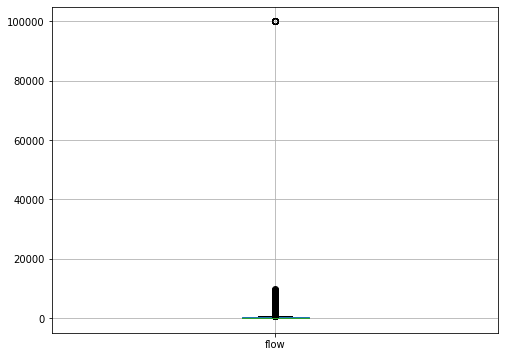

In [18]:
df.boxplot(column=['flow'])

In [19]:
bad_flow = df.loc[df['flow'] == 99999]
len(bad_flow)

31

Hay 31 mediciones con un valor erróneo para la columna `flow`: **Es necesario arreglar estos valores extremos!**

## Procesamiento del dataset

Algunos de los datos del dataset no interesan, bien porque su valor no es válido (`speed`) o bien porque
son simples identificadores (`_id` y `FID`). También se deberán formatear otras columnas:

In [20]:
df.pop('speed')
df.pop('FID')
df.pop('_id')

df.loc[:,'datetime'] = pd.to_datetime(df.loc[:,'datetime'], format='%Y-%m-%dT%H:%M:%S')

df['car_count'] = df.loc[:, 'flow'] // 12

df = df.sort_values(by='datetime')

In [21]:
df

,sensor,flow,datetime,car_count
0,PM084,12,2019-10-01 00:00:00,1
52,PM059,0,2019-10-01 00:00:00,0
51,PM017,48,2019-10-01 00:00:00,4
50,PM052,0,2019-10-01 00:00:00,0
49,PM016,48,2019-10-01 00:00:00,4
...,...,...,...,...
2758182,PM039,0,2020-02-29 23:55:00,0
2758181,PM074,0,2020-02-29 23:55:00,0
2758179,PM075,0,2020-02-29 23:55:00,0
2758186,PM024,48,2020-02-29 23:55:00,4


Acciones realizadas:
1. La columna `speed` no aporta nada, todos su valores son -9999
2. La columna `FID` tampoco, es un identificador de cada medición, al igual que `_id`
3. La columna `datetime` tuvo que ser formateada para obtener un formato válido
4. La columna `flow` es útil, pero es más interesante conocer el número de vehículos que
 pasaron sobre el sensor en los últimos 5 minutos: `car_count`
5. Se han ordenado todas las entradas por el campo `datetime`

Seleccionemos 5 mediciones al azar:

In [22]:
df.sample(n=5)

,sensor,flow,datetime,car_count
1117536,PM009,0,2019-11-07 09:45:00,0
550809,PM033,0,2019-10-28 13:10:00,0
1542694,PM013,72,2019-12-21 07:10:00,6
1170672,PM081,0,2019-12-07 22:50:00,0
2111427,PM056,288,2020-01-25 10:10:00,24


Veamos algunas estadísticas del conjunto de datos:

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.0
car_count,2904410.0,12.309273,32.616128,0.0,0.0,4.0,19.0,8333.0


Como ya se comentó en la sección anterior, existen 31 outlayers claros ( valor 99999.0 en la columna `flow`) que deben
ser eliminados:

In [24]:
df = df[df['flow'] != 99999.0]
df = df[df['car_count'] != 8333.25]

Podemos ver que ya no hay ninguna fila con `flow == 99999.0`:

In [25]:
bad_flow = df.loc[df['flow'] == 99999.0]
len(bad_flow)

0

Revisando de nuevo las estadísticas del dataset:

In [26]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
flow,2904379.0,146.999220,216.285009,0.0,0.0,48.0,228.0,9672.0
car_count,2904379.0,12.220462,18.023441,0.0,0.0,4.0,19.0,806.0


<AxesSubplot:>

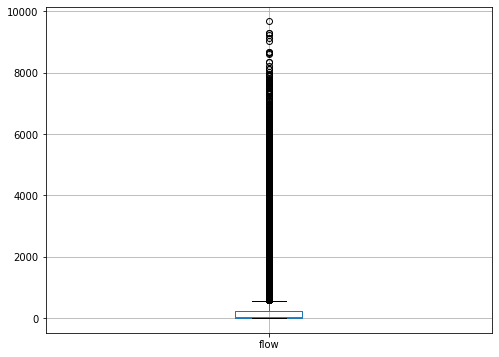

In [27]:
df.boxplot(column=['flow'])

A simple vista no se ven outlayers tan claros como anteriormente. Debido a que `flow` solo resulta de interés para
calcular `car_count`, esta característica puede ser eliminada ya del dataset.

In [28]:
df.pop('flow')

0          12
52          0
51         48
50          0
49         48
           ..
2758182     0
2758181     0
2758179     0
2758186    48
2758180     0
Name: flow, Length: 2904379, dtype: int64

## Experimentos planteados

Los experimentos a realizar consisten en predecir el tráfico en el punto en el que se ubica el
sensor `PM072` (CITIUS) en un instante `t` a partir de las mediciones realizadas por otros
sensores en un instante `t-x`. Los experimentos contemplados son los siguientes:

1. Predecir en `PM072` a partir de:
    - `PM029` (Entrada túnel Romero Donallo)
    - **No es posible, ya que ese sensor estaba averiado** - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)

2. Predecir en `PM072` a partir de:
    - `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
    - `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
    - `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - **No es posible, ya que ese sensor estaba averiado** -`PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

3. Predecir en `PM072` a partir de:
    - `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
    - `PM076` (Rúa do Horreo - Rotonda Galuresa)
    - `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
    - `PM079` (Rúa do Horreo - Rotonda Galuresa)

4. Predecir en `PM072` a partir de:
    - Todos los sensores disponibles

Para cada uno de los experimentos anteriormente citados se llevará a cabo la implementación del modelo con:
* Perceptrón multicapa
* Red Neuronal Convolucional (CNN)
* Red Neuronal Recurrente (RNN)

Asimismo, se deberá realizar un análisis de la varianza y bias para cada experimento
(Ver 6 primeras semanas Machine Learning Stanford: https://www.coursera.org/learn/machine-learning)

Por otra parte, también se probarán diversas formas de incluir las marcas temporales (timestamps) en el modelo:
* Día de la semana (1-7) y hora del día (minutos)
* Día de la semana y hora del día *modelado con sin y cos*
* Ventanas temporales (¿?)

## Experimento #1

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #1** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
* `PM029` (Entrada túnel Romero Donallo)
* **No es posible, ya que es sensor estaba averiado** - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)


### Análisis dataset Experimento #1
`
En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [29]:
sensors_list = ['PM029', 'PM072']
df_1 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [30]:
df_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
car_count,78690.0,16.797547,14.859483,0.0,4.0,13.0,26.0,92.0


Veamos un boxplot:

<AxesSubplot:>

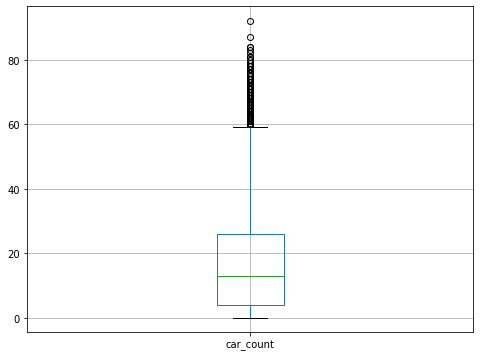

In [31]:
df_1.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`. Hay que tener en cuenta que los datos
que se encuentran fuera de la caja o de los brazos de la misma, no pueden ser considerados outlayers automáticamente.
Al tratarse de mediciones de tráfico, es evidente que a ciertas horas del día (principalmente de madrugada), el número de
coches registrado suele ser muy bajo incluso 0, por lo que la media y los cuartiles se encuentran afectados por estas
medicones.

### Análisis gráfico Experimento #1

Para ver la evolución de los datos del tráfico de manera más intuitiva se realizarán una serie de representaciones
gráficas.

La siguiente función recibe un dataframe, una lista de días y el nombre de un sensor. Grafica todas las mediciones
realizadas por ese sensor (agregados de 5 minutos) a lo largo de los días indicados

In [32]:
def plot_sensors_daily_data(df_orig, days_list, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    fig, axs = plt.subplots(days_list.shape[0], figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df.loc[(df['datetime'] >= days_list[i]) & (df['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y = df.loc[(df['datetime'] >= days_list[i]) & (df['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))

        axs[i].plot(x, y)

Podemos probar a pasarle los 7 días de una semana para ver como evoluciona el tráfico que pasa
por ese sensor durante esa semana:

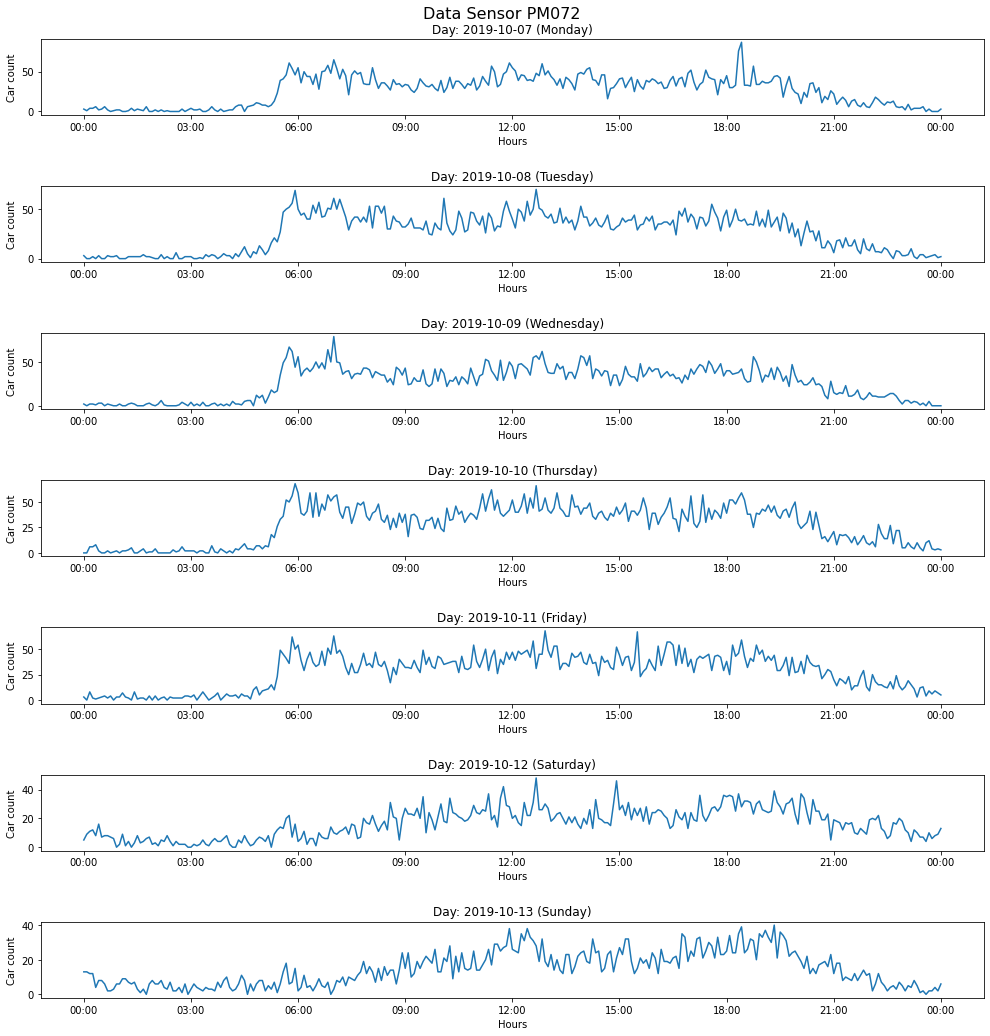

In [33]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

También podemos graficar los lunes (o cualquier día de la semana: W-SUN, W-FRI) que hubo en un mes:

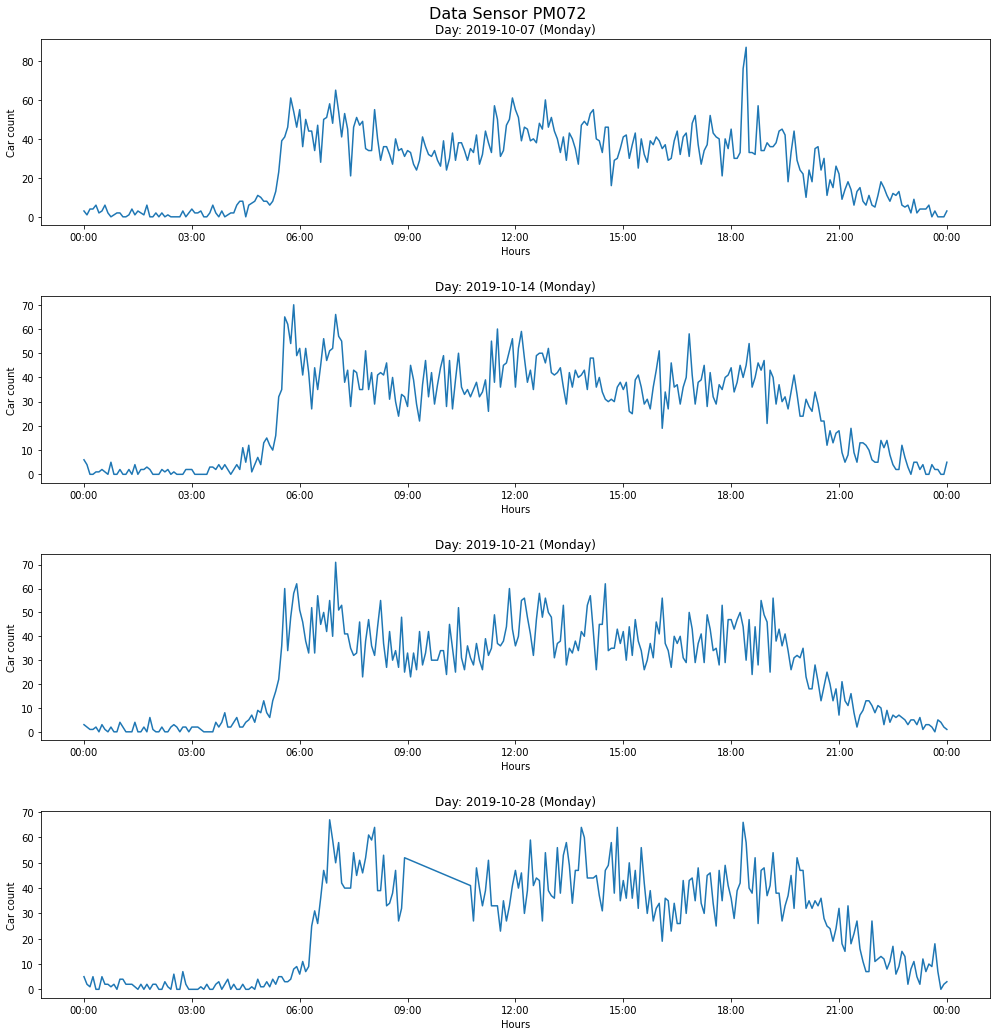

In [34]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

Las gráficas anteriores tienen mucho ruido, aunque resultan útiles para hacer una comprobación de outlayers.
Sin embargo, para ver de una manera más directa si existe periodicidad en el tráfico es más interesante **representar
los datos con agregados superiores a 5 minutos**

La siguiente función recibe un dataframe, una lista de días, un valor `n` que indica el número de mediciones agregadas,
y el nombre de un sensor. Grafica la media (mean) y desviación típica (std) de las mediciones realizadas durante el sensor
durante esos días en **agregados de 5*n minutos**

In [35]:
def plot_sensors_agregated_daily_data(df_orig, days_list, n, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    # Dataframe con los agregados
    df_mean = pd.DataFrame(columns=df.columns)
    df_std = pd.DataFrame(columns=df.columns)

    for g, df_slice in df.groupby(np.arange(len(df)) // n):
        mean_row = {'sensor': sensor, 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].mean()}
        df_mean = df_mean.append(mean_row, ignore_index=True)

        std_row = {'sensor': sensor, 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].std()}
        df_std = df_std.append(std_row, ignore_index=True)

    fig, axs = plt.subplots(days_list.shape[0], figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y_mean = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']
        y_std = df_std.loc[(df_std['datetime'] >= days_list[i]) & (df_std['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))

        axs[i].plot(x, y_mean, label='mean')
        axs[i].plot(x, y_std, label='std')
        axs[i].legend(loc='upper left')

Veamos la evolución del tráfico (media y desviación típica) durante una semana con agregados de 30 minutos (5*6)

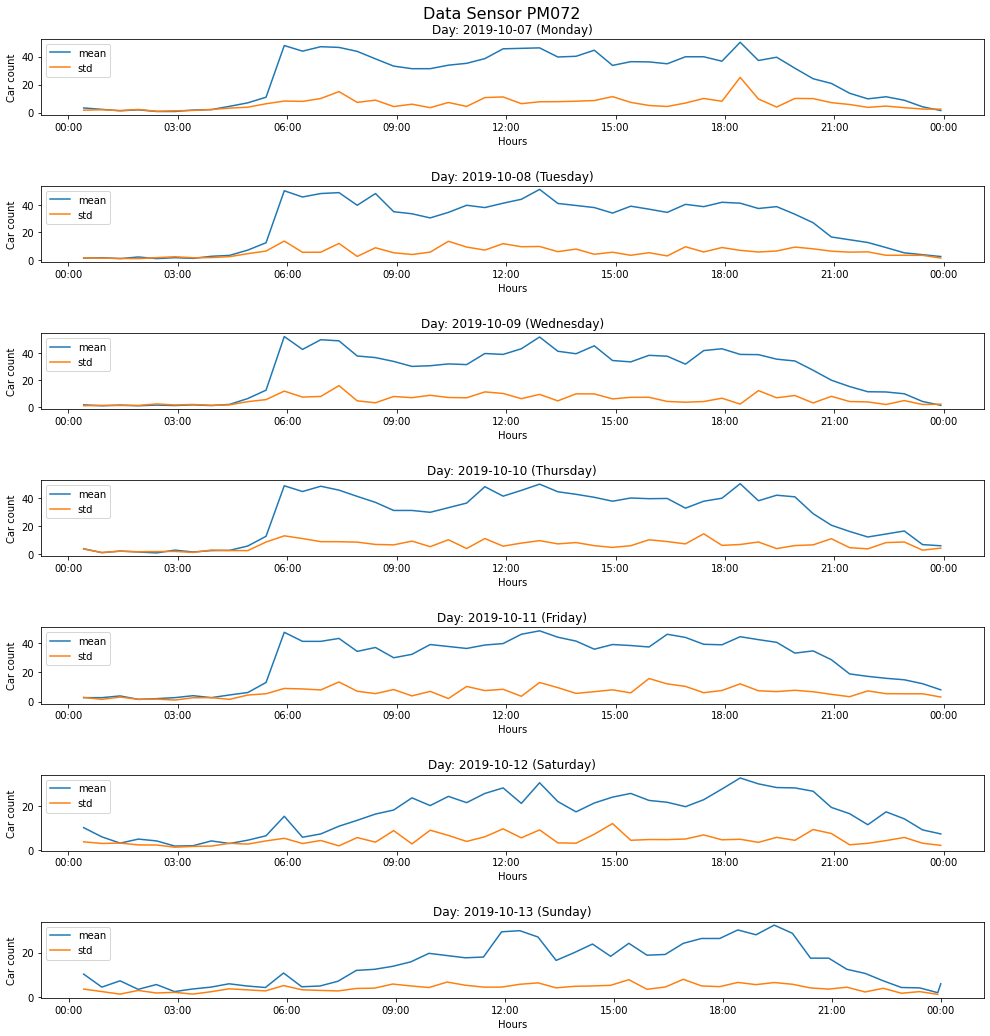

In [36]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')

Veamos la evolución del tráfico durante los lunes de un mes con agregados de 30 minutos (5*6)

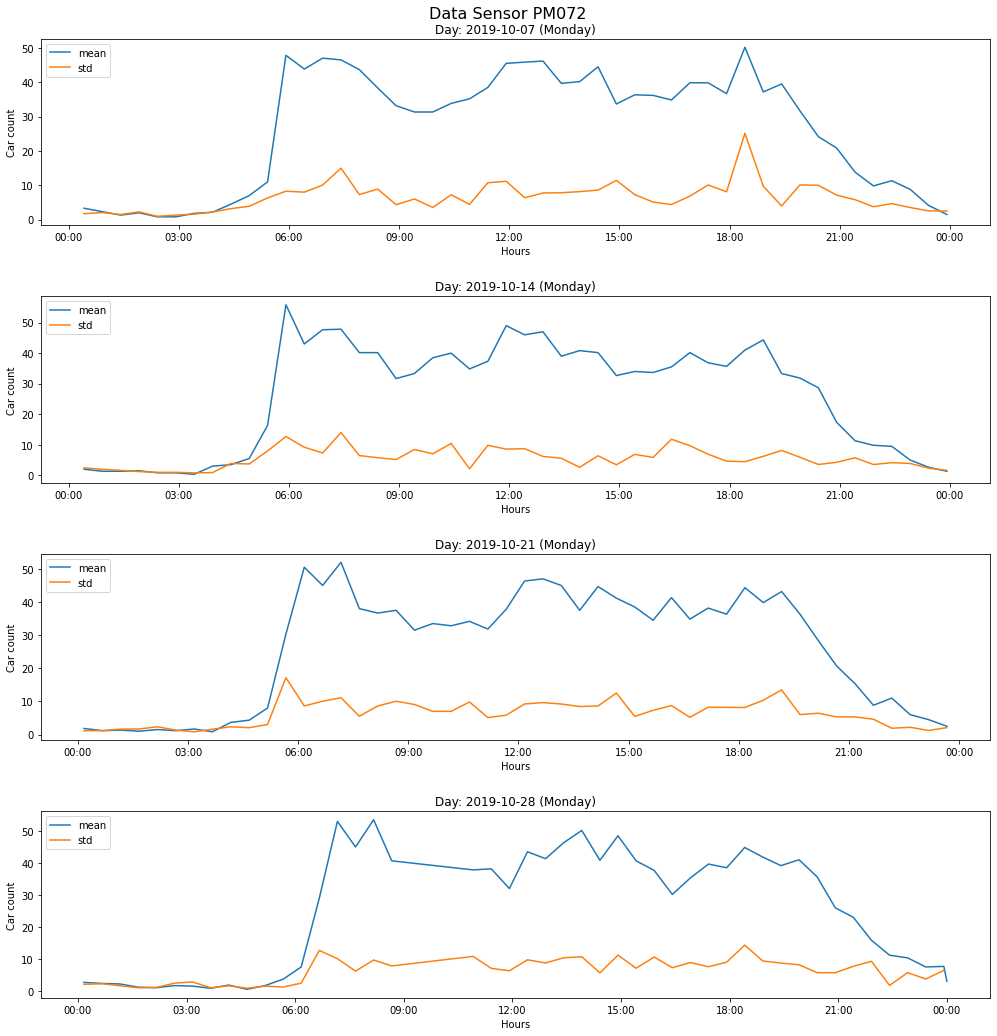

In [37]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')


### Preparación dataset Experimento #1

#### Label PM072

El objetivo del Experimento #1 es predecir el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS)
en un instante `t` a partir de las mediciones realizadas en un instante `t-x` por el sensor `PM029`.

A cualquier modelo es necesario pasarle un vector de características con el que pueda trabajar. En este caso, el vector
de características tiene la siguiente forma:

In [38]:
column_names = ['datetime', 'car_count_PM029', 'label_PM072']
pd.DataFrame(columns = column_names)

,datetime,car_count_PM029,label_PM072


Es decir, para cada instante temporal (`datetime`) que hay en el dataset, debe haber un vector de características que
contenga dicho instante temporal y el valor medido por los sensores que se usarán para predecir. Asimismo, también debe
contener el valor medido por el sensor `PM072` `x minutos` después.

Los sensores pueden fallar o detenerse por labores de mantenimiento, por lo que es posible que en algún instante temporal
uno de los sensores tome una medición y otro no, quedando así el vector de características incompleto. Esto no puede
permitirse, por lo que **si falta una medición de un sensor para un determinado instante temporal, todas las mediciones
correspondientes a dicho instante deben ser eliminadas.**

Para facilitar la preparación del dataset se ha creado la siguiente función. Recibe el dataset original, la lista de sensores
que se usarán para predecir, el sensor en el que se quiere predecir y los `x minutos` de desfase temporal.


In [39]:
def prepare_df(df_orig, sensors_list, label_sensor, x):

    # Instante temporal y car_count de dicho sensor
    prepared_df = df_orig.loc[ df_orig['sensor'] == sensors_list[0] , ['datetime', 'car_count']]
    # Renombrar la columna car_count
    prepared_df.rename(columns={'car_count': 'car_count_' + sensors_list[0]}, inplace=True)

    # INNER JOIN con los datos de cada sensor de la lista (sin contar el primero),
    # asi evito el problema de que falten mediciones de algunos sensores en un determinado instante temporal
    for ss in sensors_list[1:]:
        aux = df_orig.loc[ df_orig['sensor'] == ss, ['datetime', 'car_count']]
        aux.rename(columns={'car_count': 'car_count_' + ss}, inplace=True)
        prepared_df = pd.merge(prepared_df, aux, on='datetime', how='inner')

    # Obtengo los datos del sensor a predecir x minutos despues
    aux = df_orig.loc[ df_orig['sensor'] == label_sensor, ['datetime', 'car_count']]
    # Resto los x minutos de para poder hacer el JOIN y MANTENIENDO EL CAR_COUNT que interesa
    aux['datetime'] = aux['datetime'] - datetime.timedelta(minutes=x)
    aux.rename(columns={'car_count': 'label_' + label_sensor}, inplace=True)
    prepared_df = pd.merge(prepared_df, aux, on='datetime', how='inner')

    return prepared_df

A continuación se utiliza la función para preparar el dataset para el Experimento #1:

In [40]:
sensors_list = ['PM029']
df_1 = prepare_df(df_1, sensors_list, label_sensor='PM072', x = 5)

In [41]:
df_1.sample()

,datetime,car_count_PM029,label_PM072
32364,2020-02-07 16:30:00,18,35


#### Tiempo

Antes de construir un modelo es importante entender los datos con los que se trabaja y estar seguro que los datos
que se le pasan al modelo está correctamente formateados.

Observando ls gráficas anteriores se puede observar claramente que el tráfico tiene un comportamiento
cíclico según la *hora del día* y del *día de la semana*. Es decir, el tráfico de cada lunes durante todas las horas
del día es muy similar. A continuación se codificará este comportamiento:

#### Horas del día

Una de las formas más comunes para representar características cíclicas es mediante el uso de la función seno y la función
coseno [REFERENCIA]. En primer lugar, es necesario recuperar las horas y minutos de las fechas y convertirlo en segundos (o en minutos):

In [42]:
date_time = pd.to_timedelta(df_1['datetime'].dt.strftime('%H:%M:%S'))
date_time_s = date_time.dt.total_seconds().astype(int)

El tiempo en segundos no resulta muy útil como input para el modelo. Está claro que la periodicidad del tráfico es diaria.

Para convertir el tiempo en una señal usable se puede usar el seno y el coseno:

In [43]:
seconds_in_day = 24*60*60
df_1['hour_sin'] = np.sin(date_time_s * (2 * np.pi / seconds_in_day))
df_1['hour_cos'] = np.cos(date_time_s * (2 * np.pi / seconds_in_day))

De esta manera se logra modelar las horas como en un reloj, las 00h y están a continuación de las 23h.

La gráfica correspondiente al primer día del dataset es la siguiente ([:288] porque cada hora hay 12 mediciones * 24h = 288):

Text(0.5, 1.0, 'Time of day signal')

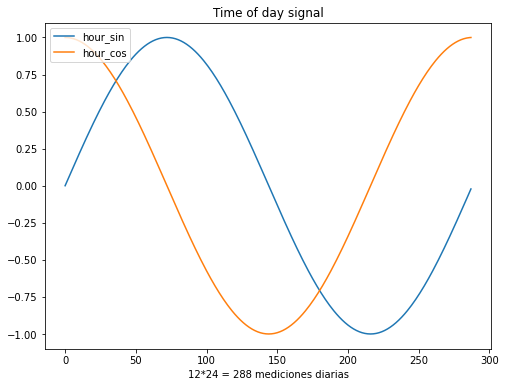

In [44]:
plt.plot(df_1[ 'hour_sin'][:288], label = 'hour_sin')
plt.plot(df_1['hour_cos'][:288], label = 'hour_cos')
plt.legend(loc='upper left')
plt.xlabel('12*24 = 288 mediciones diarias')
plt.title('Time of day signal')

Si solamente se observa la función seno, al trazar una línea horizontal se cruza en dos puntos, por lo que sólo teniendo
en cuenta esta característica, las 00:00h y las 12:00h son lo mismo. Para solucionar esto se toma en consideración el coseno, con ambas
características ya esposible distinguir esas horas y todo codificado de manera cíclica.

Una forma más intuitiva de ver lo que acabamos de hacer es representar ambas características como si se tratase un reloj:

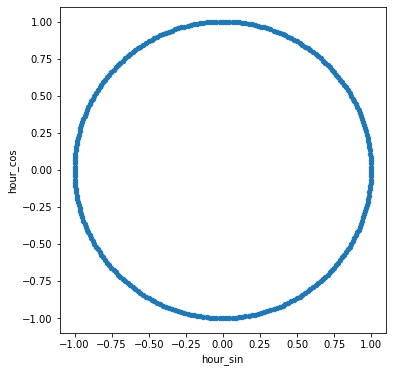

In [45]:
df_1[:288].plot.scatter('hour_sin','hour_cos').set_aspect('equal');

**Comentario personal:** Fíjate en las tablas a continuación que, evidentemente,
hour_sin` y  `hour_cos` son iguales para 2019-10-01 00:00:00 y 2019-10-02 00:00:00.
Como nos interesa que también se tenga en cuenta el día de la semana tenemos que hacer algo más!!

In [46]:
df_1[:2]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos
0,2019-10-01 00:00:00,1,0,0.000000,1.000000
1,2019-10-01 00:05:00,0,0,0.021815,0.999762


In [47]:
df_1[288:290]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos
288,2019-10-02 00:00:00,1,2,0.000000,1.000000
289,2019-10-02 00:05:00,1,4,0.021815,0.999762


#### Días de la semana

Tal y como hemos visto en las gráficas durante el `Análisis gráfico`, el tráfico tiene una clara frecuencia semanal.
Se puede ver cómo las gráficas de cada uno de los lunes (por ejemplo) son muy similares. Esto es algo que nos interesa
que nuestro modelo conozca, por lo que tenemos que realizar un trabajo similar al que hemos realizado con las horas.
*Los días de la semana también son cíclicos!*

In [48]:
wday = df_1['datetime'].dt.weekday
days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
df_1['wday_sin'] = np.sin(wday * (2 * np.pi / days_in_week))
df_1['wday_cos'] = np.cos(wday * (2 * np.pi / days_in_week))

Nuevamente, en una representación circular, vemos los 7 días de la semana:

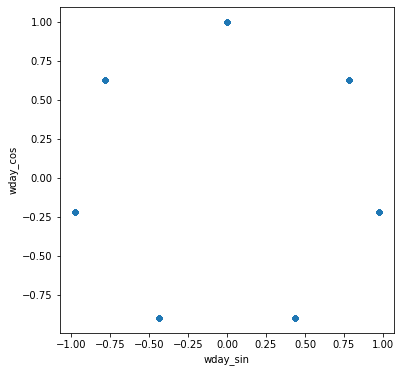

In [49]:
df_1.plot.scatter('wday_sin','wday_cos').set_aspect('equal');

**Comentario personal:** Cada uno de los 7 puntos que vemos contiene 288 puntos (hay 288 mediciones cada día).
En la siguiente tabla podemos ver como cada día de la semana (del 0 al 6) tiene un `wday_sin` y `wday_cos` diferente!!

In [50]:
df_1[0:2000:288]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos,wday_sin,wday_cos
0,2019-10-01 00:00:00,1,0,0.000000,1.000000,0.781831,0.623490
288,2019-10-02 00:00:00,1,2,0.000000,1.000000,0.974928,-0.222521
576,2019-10-03 00:00:00,0,1,0.000000,1.000000,0.433884,-0.900969
864,2019-10-04 13:50:00,18,50,-0.461749,-0.887011,-0.433884,-0.900969
1152,2019-10-05 13:50:00,5,15,-0.461749,-0.887011,-0.974928,-0.222521
1440,2019-10-06 13:50:00,10,12,-0.461749,-0.887011,-0.781831,0.623490
1728,2019-10-07 13:50:00,17,49,-0.461749,-0.887011,0.000000,1.000000


#### Características auxiliares/extra

Durante la preparación se utilizaron/crearon columnas extra en el dataset que no aportarán nada a nuestro modelo.
Estas deben ser eliminadas antes del entrenamiento.

(Se mantienen para facilitar la graficación posterior)

#### Dataset final para Experimento #1

Finalmente el dataset contiene:
1. `datetime`: Fecha y hora de la medición
2. `car_count_PM029`: Número de coches que pasaron por el sensor en los últimos 5 minutos
3. `label_PM072`: El dato a predecir
4. `hour_sin` y `hour_cos`: Hora del día codificada
5. `wday_sin` y `wday_cos`: Día de la semana codificado


Para facilitar los siguientes experimentos se ha creado la función `encode_time_sin_cos`, que hará lo comentado anteriormente:

In [51]:
def encode_time_sin_cos(enc_df):

    date_time = pd.to_timedelta(enc_df['datetime'].dt.strftime('%H:%M:%S'))
    date_time_s = date_time.dt.total_seconds().astype(int)

    seconds_in_day = 24*60*60
    enc_df['hour_sin'] = np.sin(date_time_s * (2 * np.pi / seconds_in_day))
    enc_df['hour_cos'] = np.cos(date_time_s * (2 * np.pi / seconds_in_day))

    wday = enc_df['datetime'].dt.weekday
    days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
    enc_df['wday_sin'] = np.sin(wday * (2 * np.pi / days_in_week))
    enc_df['wday_cos'] = np.cos(wday * (2 * np.pi / days_in_week))

    # Se mantiene para graficar más tarde, debe ser eliminado antes de entrenar
    #enc_df.pop('datetime')

    return enc_df

def encode_time(enc_df):

    enc_df['week_day'] = enc_df['datetime'].dt.weekday
    enc_df['hour'] = enc_df['datetime'].dt.hour
    enc_df['min'] = enc_df['datetime'].dt.minute

    enc_df.pop('datetime')

    return enc_df

### Implementación Perceptrón Multicapa

#### Definición Perceptrón Multicapa

Está en el fichero MLP_Metodología.txt y en la Memoria

#### Implementación Perceptrón Multicapa

#### División del dataset

Es necesario dividir el dataset en los conjuntos de:
* Entrenamiento: `90%`
* Validación: `10%` (Dentro del de Entrenamiento)
* Test: `10%`

**Para evitar problemas con la distribución de las mediciones es necesario hacer un `shuffle`
(reordenamiento aleatorio del dataset) antes de dividirlo.**

In [52]:
# Shuffle
df_1_shuffled=df_1.sample(frac=1).reset_index(drop=True)

n = len(df_1)
train_df_1 = df_1_shuffled[0:int(n*0.90)]
test_df_1 = df_1_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1.pop('datetime')
test_dates = test_df_1.pop('datetime')

#### Separación de las 'features' y 'labels'

Debemos separar las características del dato a predecir (`label_PM072`) en ambos conjuntos:

In [53]:
train_labels = train_df_1.pop('label_PM072')
train_features = train_df_1

test_labels = test_df_1.pop('label_PM072')
test_features = test_df_1

#### Normalización de los datos

Normalizar los datos es un paso importante para lograr un buen modelo, ya que
ayuda a que el descenso de gradiente pueda converger de manera más rápida.

La normalización debe realizarse tras la `División del dataset` y **utilizando solamente los datos de conjunto
de entrenamiento.** Esto de sebe a que el conjunto de test juega el papel de datos que aún no han sido vistos,
usar información procedente de estos datos para la normalización de todo el conjunto daría lugar a un *sesgo*
durante la evaluación del desempeño del modelo.

In [54]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [55]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(256,
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(256,
                   activation='relu'),
      layers.Dense(256,
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [56]:
model = build_and_compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________


In [57]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 9min 33s, sys: 1min 9s, total: 10min 43s
Wall time: 6min 18s


In [58]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
195,43.977470,4.870075,48.824966,5.071592,195
196,44.037823,4.875753,47.829906,5.045287,196
197,43.983006,4.869959,47.357784,5.021529,197
198,43.930630,4.868181,47.124142,5.019545,198
199,43.960514,4.872024,47.349789,5.031012,199


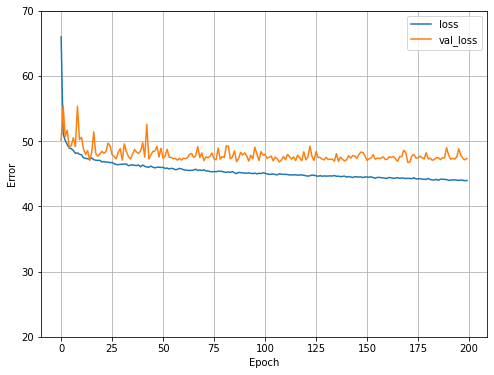

In [59]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [60]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['predictions'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

122/122 - 0s - loss: 46.3278 - mae: 4.9584
Loss (MSE):  46.32775115966797
MAE:  4.958352088928223


Tras haber realizado múltiples pruebas con las distintas arquitecturas e hiperparámetros, se ha llegado
a un modelo *vencedor*.

El MSE es una medida difícil de interpretar, ya que no está en las mismas unidades
que el problema. Por otra parte, el MAE es más fácil de interpretar, ya que este sí está en las mismas unidades.
Sin embargo, **este valor no es representativo.**

Tal y como se pudo observar en las gráficas del comienzo del trabajo,
hay determinadas horas del día en las que el número de coches es más bajo o más alto. Por ejemplo, entre las 00:00
y las 06:00 el número de coches es muy bajo, entre 5 y 10 (GENERALMENTE), mientras que en la franja de 06:00 a 18:00 
varía entre 30 y 50.

Decir que hay un error medio de 5 coches cuando pasan 60 coches es viable, no así si ese error se
da cuando pasan tan solo 2.

Para poder visualizar y comprender mejor la calidad del modelo se hará una representación gráfica a partir de los
resultados obtenidos en las predicciones con el conjunto de test. La siguiente función muestra una gráfica para cada
día de la semana en la que aparecen los datos reales y los predichos por el modelo.

**NOTA:** Cada gráfica contiene los resultados de un determinado día de la semana (p.ej, Lunes), pero ese día de la semana
puede corresponder a semanas/meses diferentes. Esto se hace para ver una representación más general, ya que no tendría
sentido representar las predicciones de cada fecha exacta.

El parámetro `freq` regula la cantidad de puntos que aparecen en cada gráfica. Se cojen puntos espaciados `freq` unidades.
Con `freq=1` se representan todos los puntos; sin embargo, resulta complicado observar 500 puntos por gráfica.


In [98]:
def graph_predictions(test_dts, test_lbls, preds, freq):
    # Como el conjunto de test es la parte final del conjunto general, los indices
    # empiezan en torno al 34 mil. Es mejor ponerlos a 0 para evitar problemas!
    test_dts.reset_index(inplace=True, drop=True)
    test_lbls.reset_index(inplace=True, drop=True)

    # Concateno las fechas, los labels y las predicciones en el mismo df
    cc_df = pd.concat([test_dts, test_lbls], axis=1)
    cc_df = pd.concat([cc_df, preds], axis=1)

    # Obtengo solo la hora de cada fecha
    cc_df['hour'] = cc_df['datetime'].dt.strftime('%H:%M')

    # Obtengo el dia de la semana [0-Lunes, 6-Domingo]
    cc_df['wday'] = cc_df['datetime'].dt.weekday

    # Ordeno por 'wday' y luego por 'hour' -> No es necesario
    cc_df = cc_df.sort_values(by=['wday', 'hour'])

    # Settings
    fig, axs = plt.subplots(7)
    fig.set_figheight(27.5)
    fig.set_figwidth(15)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Labels vs. Predictions', fontsize=16)
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Gráfica para cada día de la semana
    for i in range(7):

        axs[i].xaxis.set_major_locator(plt.MaxNLocator(12))
        axs[i].yaxis.set_major_locator(plt.MultipleLocator(10))
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title(day_names[i])

        # DataFrame para cada día de la semana
        aux = cc_df.loc[cc_df['wday'] == i]

        # Lista de horas que hay en el DataFrame para el día especificado por i
        x = aux['hour']

        # Para una determinada hora puede haber varios label y predicciones (#label == #preds)
        axs[i].scatter(x[::freq], aux['label_PM072'][::freq], label='Labels', s=10)
        axs[i].scatter(x[::freq], aux['predictions'][::freq], label='Predictions', s=10)
        axs[i].legend(loc='upper left')
        axs[i].grid()

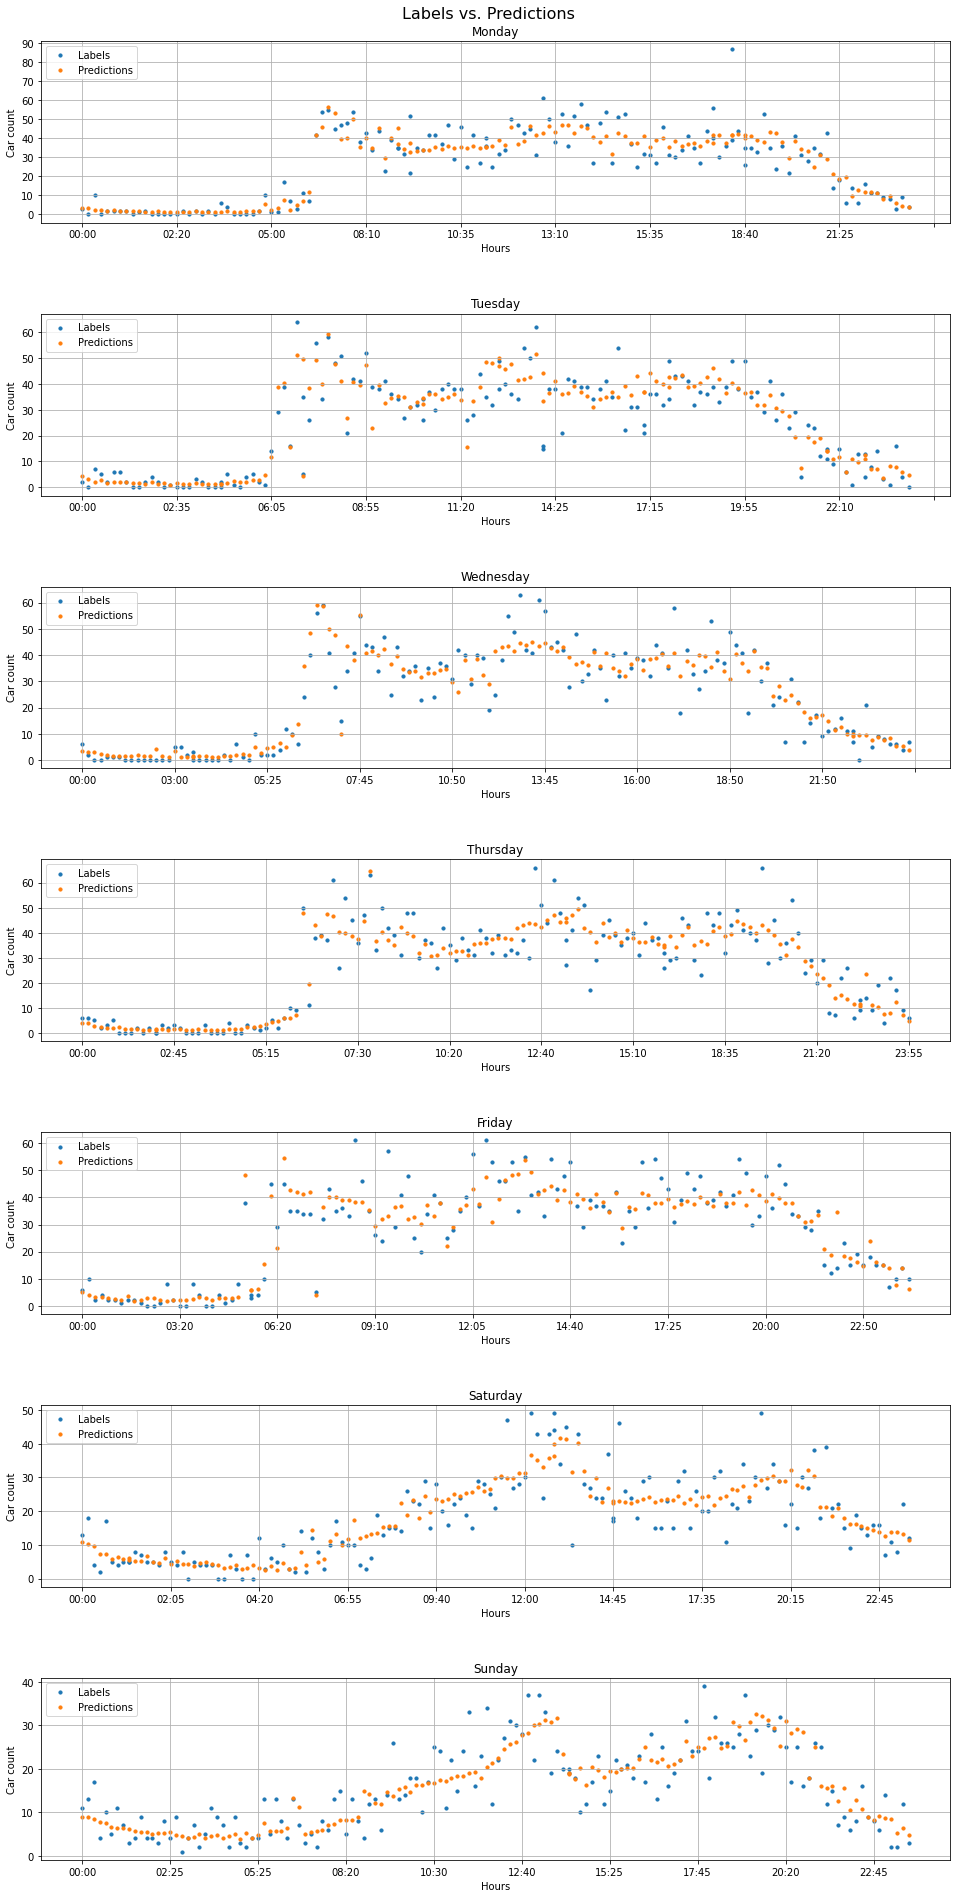

In [113]:
graph_predictions(test_dates, test_labels, predictions, freq = 4)

In [109]:
# Como el conjunto de test es la parte final del conjunto general, los indices
# empiezan en torno al 34 mil. Es mejor ponerlos a 0 para evitar problemas!
test_dates.reset_index(inplace=True, drop=True)
test_labels.reset_index(inplace=True, drop=True)

# Concateno las fechas, los labels y las predicciones en el mismo df
cc_df = pd.concat([test_dates, test_labels], axis=1)
cc_df = pd.concat([cc_df, predictions], axis=1)

# Obtengo solo la hora de cada fecha
cc_df['hour'] = cc_df['datetime'].dt.strftime('%H:%M')

# Obtengo el dia de la semana [0-Lunes, 6-Domingo]
cc_df['wday'] = cc_df['datetime'].dt.weekday

# Ordeno por 'wday' y luego por 'hour' -> No es necesario
cc_df = cc_df.sort_values(by=['wday', 'hour'])

cc_df.loc[ (cc_df['wday'] == 2) & (cc_df['hour'] > '06:35') & ((cc_df['hour'] < '08:05')) ]

,datetime,label_PM072,predictions,hour,wday
12,2019-10-16 06:40:00,49,48.756187,06:40,2
1609,2019-10-30 06:40:00,77,38.762131,06:40,2
6,2020-01-22 06:45:00,56,59.148216,06:45,2
733,2019-12-18 06:45:00,46,60.631813,06:45,2
2661,2019-11-20 06:50:00,49,46.536240,06:50,2
3034,2019-11-27 06:50:00,49,49.418877,06:50,2
3558,2019-10-23 06:50:00,59,58.902283,06:50,2
993,2020-01-01 06:55:00,12,6.070093,06:55,2
1585,2020-02-12 06:55:00,58,61.478310,06:55,2
1612,2019-10-09 07:00:00,50,53.621712,07:00,2


### Implementación RNN

#### Definición RNN

Está en el fichero Arquitecturas.txt y en la Memoria

#### Implementación LSTM

En esta sección se tratará la implementación del modelo con LSTM.

Ahora mismo el dataset para el `Experimento #1` tiene las siguientes características:

In [258]:
df_1.sample()

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos,wday_sin,wday_cos
37738,2020-02-26 08:20:00,16,30,0.819152,-0.573576,0.974928,-0.222521


Tal y como se ha comentado en `Definición RNN`, este tipo de arquitectura es capaz
de modelar el tiempo de forma explícita, por lo que ya *no es necesario* que se introduzca
la información temporal:

In [259]:
to_drop = ['wday_sin', 'wday_cos', 'hour_sin', 'hour_cos']
df_1 = df_1.drop(to_drop, axis=1)

Por otra parte, para que la red pueda modelar el tiempo de manera correcta, es necesario
que los datos que reciba estén ordenados temporalmente; es decir, por el campo `datetime`:

In [260]:
df_1 = df_1.sort_values(by=['datetime'])
df_1

,datetime,car_count_PM029,label_PM072
0,2019-10-01 00:00:00,1,0
1,2019-10-01 00:05:00,0,0
2,2019-10-01 00:10:00,0,0
3,2019-10-01 00:15:00,0,0
4,2019-10-01 00:20:00,0,1
...,...,...,...
38784,2020-02-29 23:30:00,4,8
38785,2020-02-29 23:35:00,0,7
38786,2020-02-29 23:40:00,3,11
38787,2020-02-29 23:45:00,3,22


#### División del dataset, Separación y Normalización

Cabe destacar que ahora, al utilizar una RNN (LSTM) NO se debe hacer el shuffle que
se hizo previamente al trabajar con el MLP.

In [261]:
n = len(df_1)
train_df_1 = df_1[0:int(n*0.90)]
test_df_1 = df_1[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1.pop('datetime')
test_dates = test_df_1.pop('datetime')

In [262]:
train_labels = train_df_1.pop('label_PM072')
train_features = train_df_1

test_labels = test_df_1.pop('label_PM072')
test_features = test_df_1

In [263]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

#### Entrada celda LSTM

El modelo LSTM aprenderá una función que sea capaz de asociar una serie de secuencias pasadas (inputs) a una
salida (output). Estas observaciones deben ser transformadas de tal manera que el modelo pueda aprender de ellas.

Para poder hacer esto el modelo necesita suficiente contexto; es decir, cada ejemplo que reciba debe contener
las mediciones realizadas en varios instantes temporales, pero siempre manteniendo el orden en el que estas
han sido tomadas. En TensorFlow, una capa de tipo LSTM requiere una entrada con 3D la siguiente forma [samples, timesteps, features]:
* *samples*: Número de ejemplos
* *timesteps*: El número de instantes temporales que contiene cada ejemplo
* *features*: El número de características del dataset

**EN LA MEMORIA PONER UN DIBUJO DE COMO ES LA ENTRADA 3D**

Para crear esta entrada 3D se define la siguiente función. Recibe como parámetros todas las `features`, sus `labels`
correspondientes y el número de `timesteps`. Devuelve la entrada de la capa LSTM en 3D y los `labels`
correspondientes a cada ejemplo de **x** `timesteps`:

In [264]:
def create_LSTM_data(X, y, time_steps):
    X.reset_index(inplace=True, drop=True)
    y.reset_index(inplace=True, drop=True)
    Xs, ys = [], []
    for i in range(len(X)-time_steps+1):
        v = X[i:i+time_steps]
        Xs.append(v)
        ys.append(y[i+(time_steps-1)])
    return np.array(Xs), np.array(ys)

In [265]:
train_features

,car_count_PM029
0,-1.084292
1,-1.199657
2,-1.199657
3,-1.199657
4,-1.199657
...,...
34905,0.876918
34906,-0.161369
34907,0.300092
34908,0.069361


In [ ]:
train_labels

In [266]:
train_inputs, train_outputs = create_LSTM_data(train_features, train_labels, time_steps = 3)
test_inputs, test_outputs = create_LSTM_data(test_features, test_labels, time_steps = 3)

print('train_inputs.shape: ', train_inputs.shape)
print('train_outputs.shape: ', train_outputs.shape)
print('test_inputs.shape: ', test_inputs.shape)
print('test_outputs.shape: ', test_outputs.shape)

train_inputs.shape:  (34908, 3, 1)
train_outputs.shape:  (34908,)
test_inputs.shape:  (3877, 3, 1)
test_outputs.shape:  (3877,)


In [267]:
train_inputs

array([[[-1.08429174],
        [-1.19965705],
        [-1.19965705]],

       [[-1.19965705],
        [-1.19965705],
        [-1.19965705]],

       [[-1.19965705],
        [-1.19965705],
        [-1.19965705]],

       ...,

       [[ 0.8769184 ],
        [-0.16136932],
        [ 0.30009189]],

       [[-0.16136932],
        [ 0.30009189],
        [ 0.06936128]],

       [[ 0.30009189],
        [ 0.06936128],
        [-0.16136932]]])

In [268]:
train_outputs

array([ 0,  0,  1, ..., 24, 20, 27])

Como se puede observar, cada ejemplo tiene las mediciones correspondientes a `3 instantes temporales` y tiene
asociada la medición realizada por el sensor `PM072` en el último instante temporal. **En realidad, el valor
de la medición del sensor `PM072` de cada fila corresponde a la medición realiza 5 minutos después de las
mediciones de los otros sensores de la fila!!. Esto ya se ha explicado al principio**

Ahora que ya se ha obtenido una entrada y salida adecuadas, ya es posible comenzar con el entrenamiento.

#### Entrenamiento

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.LSTM(32,
                   activation='relu', return_sequences=True,
                   input_shape=(train_inputs.shape[1], train_inputs.shape[2]) ),
      layers.LSTM(32, return_sequences=True,
                   activation='relu'),
      layers.LSTM(32,
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_inputs,
    train_outputs,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=100
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_inputs), columns = ['predictions'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_inputs, test_outputs, verbose=2)
print('Loss (MSE): ', loss)
print('MAE: ', mae)


**CUANDO HAGA EL GRAPH PREDICTIONS TENGO QUE QUITAR LAS DOS PRIMERAS FECHAS DE TEST DATES, YA QUE PARA ESAS DOS**

## Experimento #2

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #2** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
- `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
- `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
- `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
- `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
* **No es posible, ya que es sensor estaba averiado** - `PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

### Análisis dataset Experimento #2

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [ ]:
sensors_list = ['PM024', 'PM030', 'PM031', 'PM032', 'PM072']
df_2 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [ ]:
df_2.describe().transpose()

Veamos un boxplot:

In [ ]:
df_2.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`

### Análisis gráfico Experimento #2

Utilizando la función previamente creada se realizarán una serie de gráficas para ver la evolución de los datos del tráfico
de manera más intuitiva.

Para determinar si la medición en la que se registró el mayor valor para `car_count` es un outlayer se puede
representar la evolución de ese día y de otros.

In [ ]:
df_2.loc[df_2['car_count'] > 100]

In [ ]:
days = pd.date_range(start='2019-12-12', end='2019-12-14', freq='D')
plot_sensors_daily_data(df_orig=df_2, days_list = days, sensor='PM024')

En la gráfica correspondiente al `2019-12-17` se puede observar lo comentado en el anterior experimento. Los sensores
pueden fallar (o no realizar mediciones por labores de mantenimiento), por lo que, en caso de que esto suceda, **las mediciones
de los otros sensores que fueron realizados en ese mismo instante temporal deben ser descartadas.**

*De esto ya se encarga la función que ha sido creada para preparar el dataset.*

Por otra parte, la gráfica correspondiente `2019-12-18`, el día en el que se registró el máximo valor de `car_count`, se
puede observar un pico muy pronunciado. Para tener más claro si se trata de un error en la medición se pueden observar las
mediciones previas y posteriores a ese instante temporal para el sensor `PM032`:

In [ ]:
df_2.loc[(df_2['datetime'] >= '2019-12-18 10:30:00') & (df_2['datetime'] <= '2019-12-18 11:00:00') & (df_2['sensor'] == 'PM032')]

Observando las mediciones anteriores y posteriores se puede observar que no hay entradas para los 10 minutos anteriores.
**En ocasiones, los sensores se detienen o fallan y al recuperarse insertan como medición el total de coches que pasaron
durante esos minutos que estuvieron fuera de servicio. Este valor es el resultado de un error, por lo que la medición debe
ser eliminada:**

In [ ]:
df_2 = df_2[df_2['car_count'] < 100.0]

Para determinar si alguna de las mediciones con mayor cuantía de vehículos (> 90) se trataba de un error se ha seguido un
procedimiento similar. **Finalmente, se ha determinado que ninguna de esas mediciones se trata de un error.**

### Preparación dataset Experimento #2

#### Label PM072

Para este experimento, el vector de características que necesita el modelo tiene la siguiente forma:

In [ ]:
column_names = ['datetime', 'car_count_PM024', 'car_count_PM030', 'car_count_PM031', 'car_count_PM032', 'label_PM072']
pd.DataFrame(columns = column_names)

A continuación se utiliza la función para preparar el dataset para el Experimento #2:

In [ ]:
sensors_list = ['PM024', 'PM030', 'PM031', 'PM032']
df_2 = prepare_df(df_2, sensors_list, 'PM072', x = 5)

#### Tiempo

Para codificar el tiempo se usará la misma función que en el Experimento #1:

In [ ]:
df_2 = encode_time_sin_cos(df_2)
df_2.sample()

#### División del dataset, Separación y Normalización

In [ ]:
#Shuffle
df_2_shuffled=df_2.sample(frac=1).reset_index(drop=True)

n = len(df_2)
train_df_2 = df_2_shuffled[0:int(n*0.90)]
test_df_2 = df_2_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_2.pop('datetime')
test_dates = test_df_2.pop('datetime')

In [ ]:
train_labels = train_df_2.pop('label_PM072')
train_features = train_df_2

test_labels = test_df_2.pop('label_PM072')
test_features = test_df_2

In [ ]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),


  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['predictions'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
mae

In [ ]:
graph_predictions(test_dates, test_labels, predictions, freq = 4)

## Experimento #3

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #3** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
- `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
- `PM076` (Rúa do Horreo - Rotonda Galuresa)
- `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
- `PM079` (Rúa do Horreo - Rotonda Galuresa)

### Análisis dataset Experimento #3

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [ ]:
sensors_list = ['PM020', 'PM076', 'PM077', 'PM079', 'PM072']
df_3 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [ ]:
df_3.describe().transpose()

Veamos un boxplot:

In [ ]:
df_3.boxplot(column=['car_count'])

En este boxplot se pueden ver 3 outalyers muy claros. En la siguiente sección se determinará la causa de dichos valores.

### Análisis gráfico Experimento #3

Utilizando la función previamente creada se realizarán una serie de gráficas para ver la evolución de los datos del tráfico
de manera más intuitiva.

A continuación se analizarán las mediciones 'sospechosas' del boxplot anterior:

In [ ]:
df_3.loc[df_3['car_count'] > 100]

Resulta interesante ver que las 3 mediciones se produjeron en el mismo instante temporal.

En la siguiente gráfica se muestra la evolución del día anterior y siguiente al `2019-11-22` para el
sensor `PM079`:

In [ ]:
days = pd.date_range(start='2019-11-21', end='2019-11-23', freq='D')
plot_sensors_daily_data(df_orig=df_3, days_list = days, sensor='PM079')

En la gráfica correspondiente al `2019-11-22` se puede observar lo comentado en el anterior experimento. Al tratarse de
un error en las mediciones estos datos deben ser eliminados del conjunto:

In [ ]:
df_3 = df_3[df_3['car_count'] < 100]

El resto de mediciones se encuentran dentro de lo normal

### Preparación dataset Experimento #3

#### Label PM072

Para este experimento, el vector de características que necesita el modelo tiene la siguiente forma:

In [ ]:
column_names = ['datetime', 'car_count_PM020', 'car_count_PM076', 'car_count_PM077', 'car_count_PM079', 'label_PM072']
pd.DataFrame(columns = column_names)

A continuación se utiliza la función para preparar el dataset para el Experimento #3:

In [ ]:
sensors_list = ['PM020', 'PM076', 'PM077', 'PM079']
df_3 = prepare_df(df_3, sensors_list, 'PM072', x = 5)

#### Tiempo

Para codificar el tiempo se usará la misma función previamente definida:

In [ ]:
df_3 = encode_time_sin_cos(df_3)
df_3.sample()

#### División del dataset, Separación y Normalización

In [ ]:
#Shuffle
df_3_shuffled=df_3.sample(frac=1).reset_index(drop=True)

n = len(df_3)
train_df_3 = df_3_shuffled[0:int(n*0.90)]
test_df_3 = df_3_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_3.pop('datetime')
test_dates = test_df_3.pop('datetime')

In [ ]:
train_labels = train_df_3.pop('label_PM072')
train_features = train_df_3

test_labels = test_df_3.pop('label_PM072')
test_features = test_df_3

In [ ]:
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dropout(0.2),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),


  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['predictions'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
mae

In [ ]:
graph_predictions(test_dates, test_labels, predictions, freq = 4)

## Experimento #4

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #4** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t a partir de
las mediciones realizadas en un instante `t-x` por **todos los sensores de la ciudad.**

### Análisis dataset Experimento #4

En este caso se trabaja con todo el dataset, por lo que no es necesario especificar los sensores en concreto:

In [ ]:
df_4 = df

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [ ]:
df_4.describe().transpose()

Veamos un boxplot:

In [ ]:
df_4.boxplot(column=['car_count'])

En este boxplot se puede observar que hay una gran cantidad de mediciones que superan los 100 coches en 5 minutos.
Debido a la gran cantidad de mediciones que hay (en torno a 3 millones), resulta imposible realizar un análisis gráfico
como se realizó para los experimentos anteriores.

Por lo experiencia obtenida durante los anteriores experimentos y aplicando
un poco de lógica, se descartarán todas las mediciones que superen un `car_count de 200`. Esto se debe a que en los experimentos
anteriores se pudo concluir que eran outlayers debidos a errores o fallos en el funcionamiento de los sensores. Por otra parte,
un `car_count de 200` implica un flujo de 40 coches por minuto, lo cual en una ciudad como Santiago de Compostela es bastante.
Asimismo, todos los sensores están colocados en vías urbanas en las que hay tan sólo un carril y la velocidad está limitada
a 50km/h (como máximo), por lo que aplicando un poco de sentido común, es imposible que pasen 40 coches por minuto de media.

In [ ]:
df_4 = df_4.loc[df_4['car_count'] < 200]

### Preparación dataset Experimento #4

#### Label PM072

A continuación se utiliza la función para preparar el dataset para el Experimento #3:

In [ ]:
# Selecciono todos los nombres de sensores (sin repetición)
sensors_list = df_4['sensor'].unique()
# PM072 será el label
sensors_list = np.delete(sensors_list,np.where(sensors_list == 'PM072'))
# Los ordeno por comodidad
sensors_list.sort()
# Preparo el dataset
df_4 = prepare_df(df_4, sensors_list, 'PM072', x = 5)

A partir de la experiencia obtenida en los anteriores experimentos, sabemos que hay sensores que nunca contaron un coche;
es decir, su columna en este nuevo dataframe es todo 0. Como estos datos no aportan nada, dichas columnas deben ser eliminadas:

In [ ]:
df_4 = df_4.loc[:, (df_4 != 0).any(axis=0)]

Además, se ha podido observar que algunas columnas tan solo tienen un par de datos distintos de 0; es decir, tan
solo han realizado 2 mediciones de las 36790. Estas columnas también deben ser eliminadas

In [ ]:
xx = df_4.loc[:, df_4.columns != 'datetime']
aa = xx.astype(bool).sum(axis=0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(aa)

En esta lista se puede observar que los sensores `PM009`, `PM061`, `PM074` y `PM075` solo han realizado
2 mediciones a lo largo de estos 5 meses.

In [ ]:
to_drop = ['car_count_PM009', 'car_count_PM061', 'car_count_PM074', 'car_count_PM075']
df_4 = df_4.drop(to_drop, axis=1)

#### Tiempo

Para codificar el tiempo se usará la misma función previamente definida:

In [ ]:
df_4 = encode_time_sin_cos(df_4)
df_4.sample()

#### División del dataset, Separación y Normalización

In [ ]:
#Shuffle
df_4_shuffled=df_4.sample(frac=1).reset_index(drop=True)

n = len(df_4)
train_df_4 = df_4_shuffled[0:int(n*0.90)]
test_df_4 = df_4_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4.pop('datetime')
test_dates = test_df_4.pop('datetime')

In [ ]:
train_labels = train_df_4.pop('label_PM072')
train_features = train_df_4

test_labels = test_df_4.pop('label_PM072')
test_features = test_df_4

In [ ]:
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(32,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(16,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(8,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['predictions'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
mae

In [ ]:
graph_predictions(test_dates, test_labels, predictions, freq = 4)